In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
#from astroquery.mast import Observations
import lightkurve
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table
import emcee
import stella

### Using Stella to compare with Jim's flare sample for Gj1243
http://adina.feinste.in/stella/getting_started/shortest_demo.html#1.2-Using-the-Models

In [2]:
import eleanor

In [3]:
import os, sys
#sys.path.insert(1, '/Users/arcticfox/Documents/GitHub/stella/')
#/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/stella/
from tqdm import tqdm_notebook

In [4]:
#sys.path

In [5]:
ds = stella.DownloadSets()
ds.download_models()

Models have already been downloaded to ~/.stella/models


Initialize the class

In [6]:
OUT_DIR = '/Users/lupitatovar/local_flares/stella/results'

In [7]:
cnn = stella.ConvNN(output_dir=OUT_DIR)

Can only use stella.ConvNN.predict().


### Importing in lightcurve for GJ1243

In [8]:
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
#target = '273589987'
target='9726699'
gj1243_tess = search_lightcurvefile(target,cadence='short',mission='TESS').download_all()

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  """


In [9]:
tess_collection=gj1243_tess[-2:]
#tess_collection

In [10]:
s14 = tess_collection[0].PDCSAP_FLUX.remove_nans()
s15 = tess_collection[1].PDCSAP_FLUX.remove_nans()

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  """Entry point for launching an IPython kernel.
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  


In [11]:
gj1243_tesslc = tess_collection[0].PDCSAP_FLUX.remove_nans()

for q in range(1,len(tess_collection)):
    try:
        gj1243_tesslc = gj1243_tesslc.append(tess_collection[q].PDCSAP_FLUX).remove_nans()
    except:
            print(q)

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  """Entry point for launching an IPython kernel.
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  """


<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

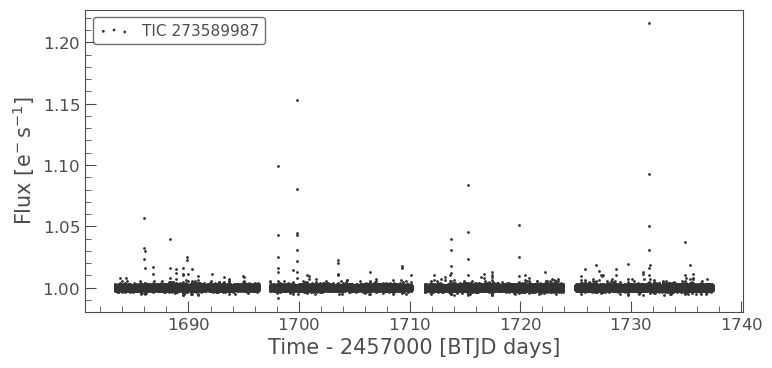

In [12]:
flat_lc = gj1243_tesslc.flatten(window_length=11)
flat_lc.scatter()
#gj1243_tesslc.scatter()

In [ ]:
flat_lc.time

In [14]:
cnn.predict(modelname=ds.models[0],
            times=flat_lc.time.btjd,
            fluxes=flat_lc.flux,
            errs=flat_lc.flux_err)
single_pred = cnn.predictions[0]

100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


In [15]:
cnn.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 200, 16)           64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 16)           0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 64)           3136      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0

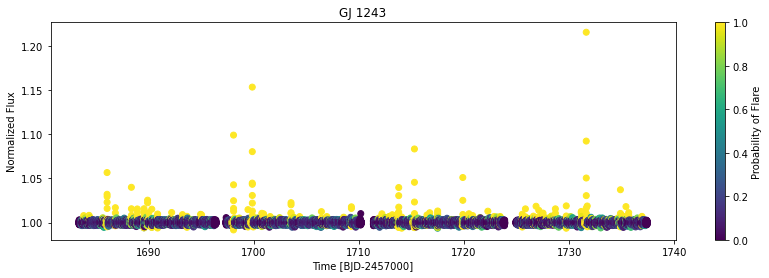

In [17]:
plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=single_pred, vmin=0, vmax=1)
plt.colorbar(label='Probability of Flare')
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')
plt.title('GJ 1243');

In [18]:
#ensembling
preds = np.zeros((len(ds.models),len(cnn.predictions[0])))

for i, model in enumerate(ds.models):
    cnn.predict(modelname=ds.models[0],
                times=flat_lc.time.btjd,
                fluxes=flat_lc.flux,
                errs=flat_lc.flux_err)
    preds[i] = cnn.predictions[0]

avg_pred = np.nanmedian(preds, axis=0)

100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


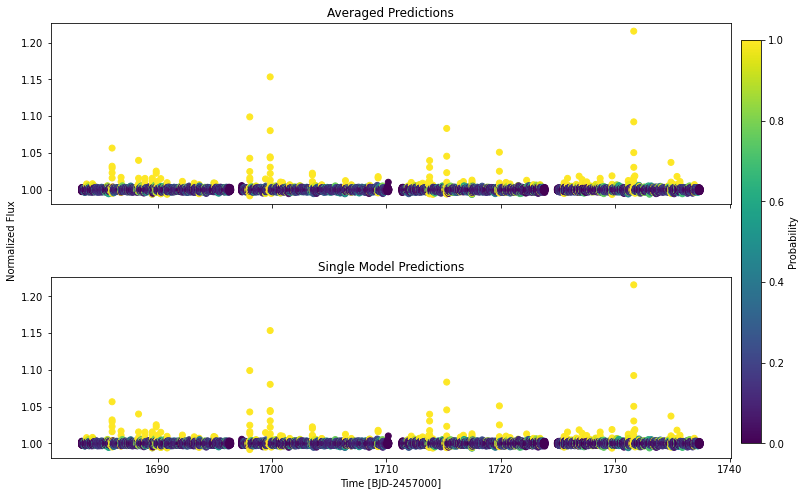

In [19]:
fig, (ax1, ax2) = plt.subplots(figsize=(14,8), nrows=2,
                               sharex=True, sharey=True)
im = ax1.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=avg_pred, vmin=0, vmax=1)
ax2.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=single_pred, vmin=0, vmax=1)
ax2.set_xlabel('Time [BJD-2457000]')
ax2.set_ylabel('Normalized Flux', y=1.2)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Probability')


ax1.set_title('Averaged Predictions')
ax2.set_title('Single Model Predictions')

plt.subplots_adjust(hspace=0.4);

(1733.0, 1735.0)

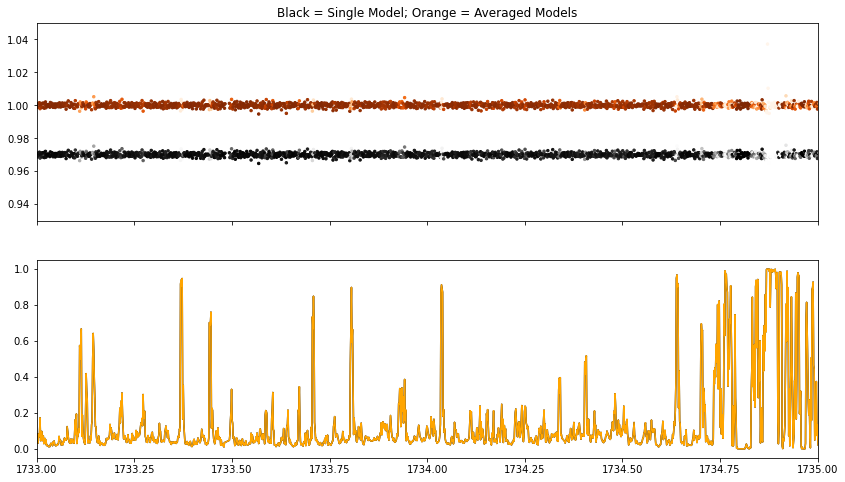

In [20]:
#zooming in to see differences
fig, (ax1, ax2) = plt.subplots(figsize=(14,8), nrows=2,
                               sharex=True)
ax1.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=avg_pred, vmin=0, vmax=1, cmap='Oranges_r', s=6)
ax1.scatter(cnn.predict_time[0], cnn.predict_flux[0]-0.03,
            c=single_pred, vmin=0, vmax=1, cmap='Greys_r', s=6)
ax1.set_ylim(0.93,1.05)
ax2.plot(cnn.predict_time[0], single_pred, 'k')
ax2.plot(cnn.predict_time[0], avg_pred, 'orange')
ax1.set_title('Black = Single Model; Orange = Averaged Models')

#plt.xlim(1699,1705)
plt.xlim(1733,1735)

### Measuring Rotation Period : http://adina.feinste.in/stella/getting_started/other_features.html
Rotation Period was established from light curve modulations by two starspots in the first release of Kepler data (Savanov & Dmitrienko 2011), and independently discovered from ground-based data by Irwin et al. (2011). P = 0.592 and stella recovers the same value

In [21]:
s14.time

<Time object: scale='tdb' format='btjd' value=[1683.35617589 1683.3575648  1683.35895371 ... 1710.20359189 1710.20498078
 1710.20636967]>

In [22]:
mProt_14 = stella.MeasureProt([target], [s14.time.btjd], [s14.flux], [s14.flux_err])
mProt_15 = stella.MeasureProt([target], [s15.time.btjd], [s15.flux], [s15.flux_err])

In [23]:
mProt_14.run_LS()
mProt_15.run_LS()

Finding most likely periods: 100%|██████████| 1/1 [00:00<00:00, 16.74it/s]


In [24]:
mProt_14.LS_results

Target_ID,period_days,secondary_period_days,gauss_width,max_power,secondary_max_power,orbit_flag,oflag1,oflag2,Flags,avg_period_days
str7,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
9726699,0.5926969380594846,0.5924234938039095,0.009974527032471626,0.5408617922290281,0.09906267135174686,0.0,0.0,0.0,0,0.5926969380594846


In [25]:
mProt_15.LS_results

Target_ID,period_days,secondary_period_days,gauss_width,max_power,secondary_max_power,orbit_flag,oflag1,oflag2,Flags,avg_period_days
str7,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
9726699,0.5935048466649321,0.5933696087768825,0.010254086714809344,0.6672466355818547,0.1227854042445978,0.0,0.0,0.0,0,0.5935048466649321


<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

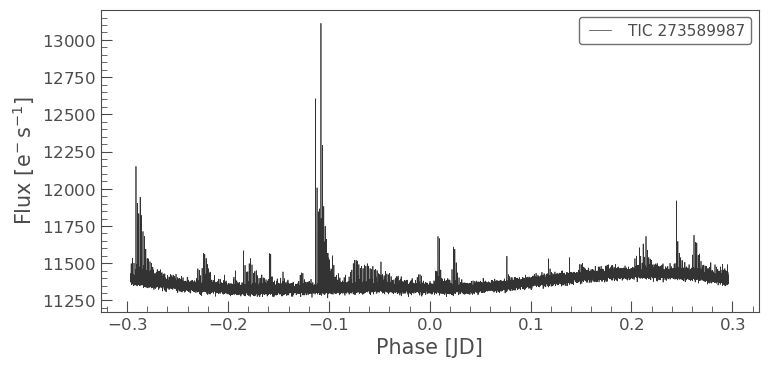

In [26]:
s14.fold(mProt_14.LS_results['avg_period_days'].data[0]).plot()

<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

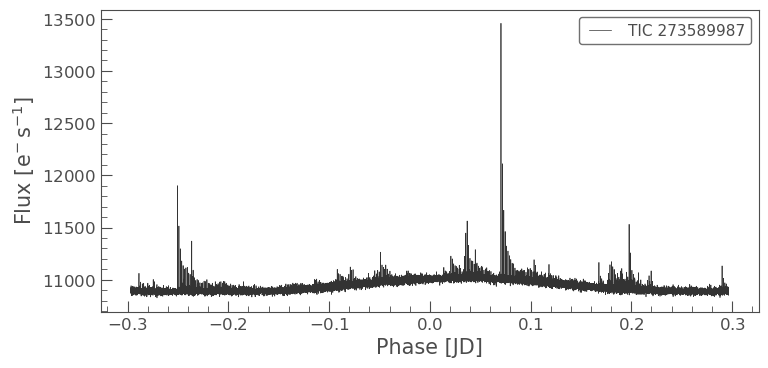

In [27]:
s15.fold(mProt_15.LS_results['avg_period_days'].data[0]).plot()

### Fitting Flares with Stella

In [28]:
MODEL_DIR = '/Users/lupitatovar/.stella/models'
MODEL = [os.path.join(MODEL_DIR,i) for i in
          os.listdir(MODEL_DIR) if i.endswith('.h5')][0]

In [29]:
# fitting the flares
ff = stella.FitFlares(id=[target],
                      time=[flat_lc.time.btjd],
                      flux=[flat_lc.flux.value],
                      flux_err=[flat_lc.flux_err.value],
                      predictions=[cnn.predictions[0]])

In [58]:
flat_lc.flux.value

array([0.99940654, 1.00090786, 0.99979793, ..., 0.99984561, 0.99830835,
       1.00132053])

In [30]:
ff.identify_flare_peaks(threshold=0.5)

ff.flare_table

Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(results)
Finding & Fitting Flares: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


Target_ID,tpeak,amp,ed_s,rise,fall,prob
float64,float64,float64,float64,float64,float64,float64
9726699.0,1683.8034041885226,1.007841070530858,1.3591946056789421,0.0001,0.0011567613173870915,0.9967183470726013
9726699.0,1685.7325952727629,1.003080437150728,0.5346416984515456,0.0001,0.0011050776888382088,0.9286727905273438
9726699.0,1686.028432240426,1.0569463578389093,20.253854810133767,0.0001,0.003405635177730015,1.0
9726699.0,1686.028432240426,1.0569463578389093,20.253854810133767,0.0001,0.003405635177730015,1.0
9726699.0,1686.028432240426,1.0569463578389093,20.253854810133767,0.0001,0.003405635177730015,1.0
9726699.0,1686.815941809787,1.0167357073927867,4.039117641551494,0.0001,0.0019571248100425857,0.9999997615814209
9726699.0,1686.815941809787,1.0167357073927867,4.039117641551494,0.0001,0.0019571248100425857,0.9999997615814209
9726699.0,1687.7173414700178,1.002806604061081,0.5462759848710682,0.0001,0.0014289809425205233,0.6869086623191833
9726699.0,1687.7173414700178,1.002806604061081,0.5462759848710682,0.0001,0.0014289809425205233,0.6869086623191833


In [33]:
flare = [ff.flare_table[ff.flare_table['prob'] == 1.0]]
gt_5=[ff.flare_table[ff.flare_table['prob'] >= 0.5]]
print((flare))
print(gt_5)
#74 instances where probability of a flare = 1 

[<Table length=52>
Target_ID       tpeak        ...          fall           prob 
 float64       float64       ...        float64        float64
--------- ------------------ ... --------------------- -------
9726699.0  1686.028432240426 ...  0.003405635177730015     1.0
9726699.0  1686.028432240426 ...  0.003405635177730015     1.0
9726699.0  1686.028432240426 ...  0.003405635177730015     1.0
9726699.0 1688.3423488276135 ... 0.0016661647167149456     1.0
9726699.0 1688.3423488276135 ... 0.0016661647167149456     1.0
9726699.0 1688.3423488276135 ... 0.0016661647167149456     1.0
9726699.0 1688.3423488276135 ... 0.0016661647167149456     1.0
9726699.0 1688.3423488276135 ... 0.0016661647167149456     1.0
9726699.0 1689.8840332767768 ... 0.0017932503381505739     1.0
9726699.0 1689.8840332767768 ... 0.0017932503381505739     1.0
      ...                ... ...                   ...     ...
9726699.0 1731.6172702369001 ...  0.001894086344191023     1.0
9726699.0 1731.6172702369001 ...  0.

Marking the flares

(0.99, 1.02)

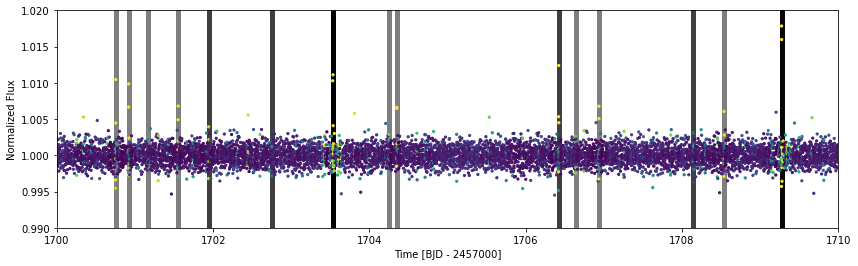

In [34]:
plt.figure(figsize=(14,4))
plt.scatter(ff.time[0], ff.flux[0], c=cnn.predictions[0], s=5)

for tpeak in ff.flare_table['tpeak']:
    plt.vlines(tpeak, 0,2, color='k', alpha=0.5, linewidth=5, zorder=0)

plt.ylim(0.94,1.3)
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('Normalized Flux');
plt.xlim(1700,1710)
plt.ylim(0.99,1.02)

### Per sector flares

Sector 14 Flares

In [35]:
cnn_fit_14 = stella.ConvNN(output_dir='.')
cnn_fit_14.predict(modelname=MODEL,
            times=s14.time.btjd,
            fluxes=s14.flux,
            errs=s14.flux_err)

  0%|          | 0/1 [00:00<?, ?it/s]

Can only use stella.ConvNN.predict().


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


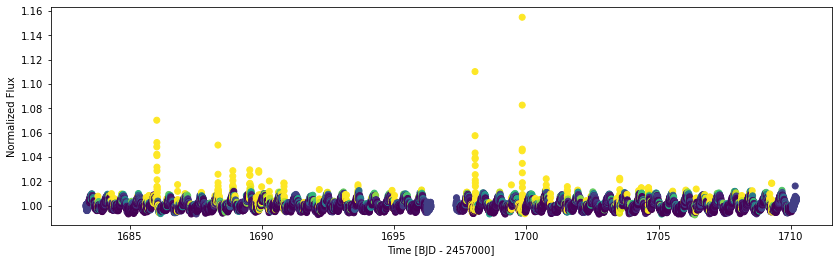

In [36]:
plt.figure(figsize=(14,4))
plt.scatter(cnn_fit_14.predict_time[0], cnn_fit_14.predict_flux[0], c=cnn_fit_14.predictions[0], vmin=0, vmax=1)
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('Normalized Flux');

In [37]:
s14.targetid

273589987

In [38]:
target

'9726699'

In [39]:
cnn_fit_14.predictions[0]

array([0.18410772, 0.18410772, 0.18410772, ..., 0.18410772, 0.18410772,
       0.18410775], dtype=float32)

In [40]:
#S14
ff14 = stella.FitFlares(id=[s14.targetid],
                      time=[s14.time.btjd],
                      flux=[s14.flux.value],
                      flux_err=[s14.flux_err.value],
                      predictions=[cnn_fit_14.predictions[0]])

In [41]:
ff14.identify_flare_peaks(threshold=0.5)

ff14.flare_table

Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(results)
Finding & Fitting Flares: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Target_ID,tpeak,amp,ed_s,rise,fall,prob
float64,float64,float64,float64,float64,float64,float64
273589987.0,1688.9881896712468,1.0062684847372938,7.292271459934418,0.01,0.003281357090428864,0.9973636269569397
273589987.0,1691.907667110957,1.007784118516363,15.57188215256548,0.01,0.01,0.6728654503822327


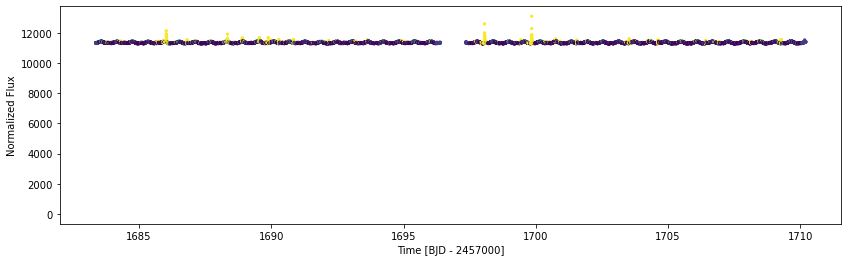

In [52]:
plt.figure(figsize=(14,4))
plt.scatter(ff14.time[0], ff14.flux[0], c=cnn_fit_14.predictions[0], s=5)

for tpeak in ff14.flare_table['tpeak']:
    plt.vlines(tpeak, 0,2, color='k', alpha=0.5, linewidth=5, zorder=0)

#plt.ylim(0.94,1.3)
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('Normalized Flux');


Sector 15 Flares

In [44]:
cnn_fit_15 = stella.ConvNN(output_dir='.')
cnn_fit_15.predict(modelname=MODEL,
            times=s15.time.btjd,
            fluxes=s15.flux,
            errs=s15.flux_err)

  0%|          | 0/1 [00:00<?, ?it/s]

Can only use stella.ConvNN.predict().


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


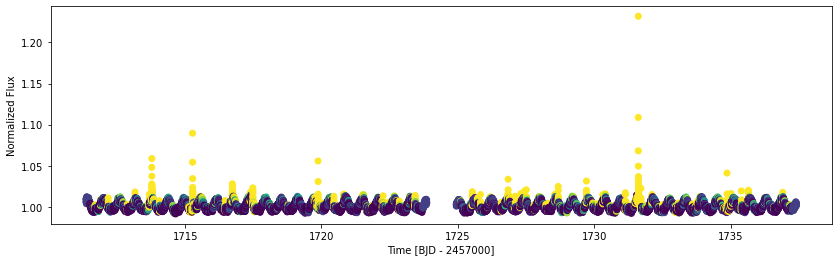

In [45]:
plt.figure(figsize=(14,4))
plt.scatter(cnn_fit_15.predict_time[0], cnn_fit_15.predict_flux[0], c=cnn_fit_15.predictions[0], vmin=0, vmax=1)
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('Normalized Flux');

In [46]:
#S15
# fitting the flares
ff15 = stella.FitFlares(id=[target],
                      time=[s15.time.btjd],
                      flux=[s15.flux.value],
                      flux_err=[s15.flux_err.value],
                      predictions=[cnn_fit_15.predictions[0]])

In [47]:
ff15.identify_flare_peaks(threshold=0.5)

ff15.flare_table

Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(results)
Finding & Fitting Flares: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Target_ID,tpeak,amp,ed_s,rise,fall,prob
float64,float64,float64,float64,float64,float64,float64
9726699.0,1715.0146784611275,1.0088868340273893,19.222741316754984,0.01,0.01,0.6089034080505371
9726699.0,1720.9937987375217,1.0033935997034384,1.8696995845170956,0.0027736115789260525,0.007382030718647171,0.5593361258506775
9726699.0,1722.1382343236437,1.0068984044164186,14.006537023712397,0.01,0.01,0.5324165225028992
9726699.0,1729.878410834627,1.0027069423473092,2.768833068891916,0.0030138769078253682,0.008009886774558824,0.502739667892456
9726699.0,1735.1574873150992,1.009108431978765,20.217851350912035,0.01,0.01,0.7419126629829407
9726699.0,1735.1574873150992,1.009108431978765,20.217851350912035,0.01,0.01,0.7419126629829407
9726699.0,1736.3741339544035,1.0045353615246981,4.624553135596795,0.003018434114911729,0.008001853085827158,0.6687672138214111
9726699.0,1736.3741339544035,1.0045353615246981,4.624553135596795,0.003018434114911729,0.008001853085827158,0.6687672138214111


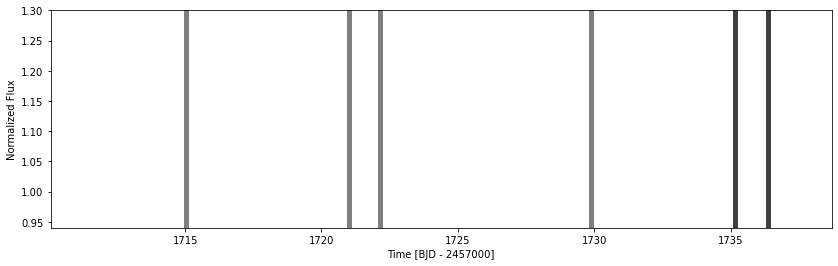

In [51]:
plt.figure(figsize=(14,4))
plt.scatter(ff15.time, ff15.flux, c=cnn_fit_15.predictions[0], s=5)

for tpeak in ff15.flare_table['tpeak']:
    plt.vlines(tpeak, 0,2, color='k', alpha=0.5, linewidth=5, zorder=0)

plt.ylim(0.94,1.3)
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('Normalized Flux');


In [50]:
ff15.time

[array([1711.36748015, 1711.36886903, 1711.37025791, ..., 1737.40884054,
        1737.4102294 , 1737.41161827])]